# MolGAN


As chapter 11 of the [book](https://www.amazon.com/Hands-Graph-Neural-Networks-Python/dp/1804617520) details generative adverserial networks (GANs) can also be used to generate graphs which is really important when it comes to molecular design. Then through methods such as [Retrosynthetic Planning and Reaction Prediction](https://arxiv.org/html/2411.08306v2) these generated molecules can potentially be created in a real lab to create new molecules for applications such as drugs and materials. GANs can help with the first part of this two step process by generating/designing potentially new molecules that may be later determined to be synthesizable in the lab.


The book implements [MolGan: An implicit generative model for small molecular graphs](https://arxiv.org/abs/1805.11973) which came out in 2018 (and later revised in 2022) to generate molecules. MolGan is interesting not only because it uses GANs to generate graphs but also because it uses reinforcement learning (RL).


As the book details:




> MolGAN combines a [Wasserstein GAN (WGAN)](https://en.wikipedia.org/wiki/Wasserstein_GAN) with a gradient penalty that directly processes graph-structured data and an RL objective to generate molecules with desired chemical properties. This RL objective is based on the [Deep Deterministic Policy Gradient (DDPG) algorithm](https://spinningup.openai.com/en/latest/algorithms/ddpg.html), an off-policy actor-critic model that uses deterministic policy gradients.


The architecture is divided into three main components:


1.  The Generator
2.  The Discriminator
3.  The Reward Network


The Generator takes as input noise and processes it to output two matrices: an annotation matrix X which contains the different atom/node types and an adjacency matrix A which represents the bonds/edges of the molecule.The Generator is trained using a linear combination of the WGAN and RL loss and uses [categorical sampling](https://en.wikipedia.org/wiki/Categorical_distribution) to transform these dense matrix representations into sparse matrices i.e., $\tilde{A},\tilde{X} \sim P(A,X)$ The following code snippet details the forward architecture of MolGAN's [Generator](https://github.com/deepchem/deepchem/blob/master/deepchem/models/torch_models/molgan.py):

```
if isinstance(inputs, list):
  inputs = inputs[0]
x = F.tanh(self.dense1(inputs))
x = self.dropout1(x)
x = F.tanh(self.dense2(x))
x = self.dropout2(x)
x = F.tanh(self.dense3(x))
x = self.dropout3(x)
# edges logits
edges_logits = self.edges_dense(x)
edges_logits = edges_logits.view(-1, self.edges, self.vertices,
                                         self.vertices)
matrix_transpose = edges_logits.permute(0, 1, 3, 2)
edges_logits = (edges_logits + matrix_transpose) / 2
edges_logits = edges_logits.permute(0, 2, 3, 1)
edges_logits = self.edges_dropout(edges_logits)

# nodes logits
nodes_logits = self.nodes_dense(x)
nodes_logits = nodes_logits.view(-1, self.vertices, self.nodes)
nodes_logits = self.nodes_dropout(nodes_logits)

if sample_generation is False:
  # For training
  edges = F.softmax(edges_logits, dim=-1)
  nodes = F.softmax(nodes_logits, dim=-1)
else:
  # For sample generation
  e_gumbel_logits = edges_logits - torch.log(-torch.log(
                torch.rand_like(edges_logits, dtype=edges_logits.dtype)))
  e_gumbel_argmax = F.one_hot(torch.argmax(e_gumbel_logits, dim=-1),
  num_classes = e_gumbel_logits.shape[-1])
  edges = torch.argmax(e_gumbel_argmax, dim=-1)

  n_gumbel_logits = nodes_logits - torch.log(-torch.log(
                    torch.rand_like(nodes_logits, dtype=nodes_logits.dtype)))
  n_gumbel_argmax = F.one_hot(torch.argmax(n_gumbel_logits, dim=-1),
                                        num_classes=n_gumbel_logits.shape[-1])
  nodes = torch.argmax(n_gumbel_argmax, dim=-1)
  return [edges, nodes]

```


The Discriminator receives graphs from the Generator and the dataset and distinguishes them from being real versus fake molecules. And the reward network scores each graph that was created i.e., how realistic the generated molecule actually is. Both the discriminator and reward network are implemented using the [relational-GCN](https://www.dgl.ai/dgl_docs/en/2.3.x/tutorials/models/1_gnn/4_rgcn.html) a GNN that supports multiple edge types representing the different [chemical bonds](https://en.wikipedia.org/wiki/Chemical_bond).


To implement MolGAN we use the library DeepChem which is tensorflow based but can also be used with pytorch. In fact, to make this book exercise work the pytorch implementation from the [tutorial](https://deepchem.io/tutorials/generating-molecules-with-molgan/) is used instead since there are problems integrating tensorflow's encoding function  [one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot) with the batch training step/loop.



In [ ]:
!pip install deepchem=='2.8.1.dev20251209033047'
import deepchem
deepchem.__version__

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import pandas as pd
from torch.nn.functional import one_hot
import deepchem as dc
import torch
from deepchem.models.optimizers import ExponentialDecay
from deepchem.models.torch_models import BasicMolGANModel as MolGAN
from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import IPythonConsole

## Tox21 Dataset

MolGAN is trained on the Tox21 Dataset which consists of 12,060 training samples and 647 test samples and stems from the [Tox21 challenge](https://tripod.nih.gov/tox21/challenge/) which was a government sponsored challenge to predict the toxicity of 10,000 known compounds/molecules using 12 binary features representing the outcome (i.e., active/inactive) of 12 different toxicological experiments. In this case, we will be using the [SMILES](https://en.wikipedia.org/wiki/Simplified_Molecular_Input_Line_Entry_System) labels of the Tox21 compounds/molecules to generate potentially new compounds/molecules rahter than trying to predict [toxicity](https://en.wikipedia.org/wiki/Toxicity).

In [5]:
# loading the SMILES dataset
_, datasets, _ = dc.molnet.load_tox21()
df = pd.DataFrame(datasets[0].ids, columns=['smiles'])

In [6]:
df.shape

(6258, 1)

In [7]:
df.head()

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C


In [8]:
# limiting the number of atoms to encode per molecule
max_atoms = 12
molecules = [x for x in df['smiles'].values if Chem.MolFromSmiles(x).GetNumAtoms() < max_atoms]

[02:26:20] WARNING: not removing hydrogen atom without neighbors


## Featurizing the Molecules for MolGAN

For each molecule in the original dataset we need to extract features to train the MolGAN model. This is done with the [MolGanFeaturizer](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/molecule_featurizers/molgan_featurizer.py#L60-L120) which takes the original SMILES encoding for a molecule e.g., CC(O)(P(=O)(O)O)P(=O)(O)O and transforms it into its corresponding [lewis structure(s)](https://en.wikipedia.org/wiki/Lewis_structure), atoms, and bonds. This is done with the following arguments:


*   **max_atom_count** (int, default 9) – Maximum number of atoms used for creation of adjacency matrix. Molecules cannot have more atoms than this number Implicit hydrogens do not count.

*   **kekulize** (bool, default True) – Should molecules be kekulized i.e., generating alternative bond connectivity for molecule

*   **bond_labels** (List[RDKitBond](https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/Bond.cpp)) – List of types of bonds used for generation of adjacency matrix

*   **atom_labels** (List[int]) – List of [atomic labels](https://github.com/rdkit/rdkit/blob/master/Code/GraphMol/Atom.cpp) used for generation of node features


In this case the max number of atoms to extract from SMILES will be 12, [kekulization](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/molecule_featurizers/molgan_featurizer.py#L60-L120) will be true, [bond_labels](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/molecule_featurizers/molgan_featurizer.py#L60-L120) will be none (which means only zero, single, double, triple and aromatic bonds will be extracted), and the [atom_labels](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/molecule_featurizers/molgan_featurizer.py#L60-L120) will be 0, 5, 6, 7, 8, 9, 11, 12, 13, 14 (which means only C,B, N, O, F,Ne, Mg, Al, Si, P will be extracted I think lol)

After creating the featurizer with our featurized extraction settings, we then iterate through each molecule in the SMILES dataset and apply the [canonical rank](https://gist.github.com/ptosco/a9b9bc5309e3114b89fcc4aefdef9f57) to each molecule. Lastly,  we apply the [featureizer](https://github.com/deepchem/deepchem/blob/master/deepchem/feat/molecule_featurizers/molgan_featurizer.py#L60-L120) to the ranked molecule to create the A and X matrices   


In [65]:
# features we want to extract from SMILES
featurizer = dc.feat.MolGanFeaturizer(max_atom_count=max_atoms, atom_labels=[0, 5, 6, 7, 8, 9, 11, 12, 13, 14])

In [ ]:
features = []
for x in molecules:
  mol = Chem.MolFromSmiles(x)
  # getting canonical rank for SMILES mol
  new_order = rdmolfiles.CanonicalRankAtoms(mol)
  # renumbering atoms with canonical rank
  mol = rdmolops.RenumberAtoms(mol, new_order)
  # creating GraphMatrix with our extracted settings
  feature = featurizer.featurize(mol)
  if feature.size != 0:
    features.append(feature[0])
features = [x for x in features if type(x) is GraphMatrix]
dataset = dc.data.NumpyDataset(X=[x.adjacency_matrix for x in features], y=[x.node_features for x in features])

In [68]:
# adjaceny feature matrix/A/bonds
dataset.X.shape

(1368, 12, 12)

In [69]:
# node feature matrix/X/atoms
dataset.y.shape

(1368, 12)

## Batched Training Loop

In [70]:
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=max_atoms)
# function to feed input to Molgan
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            flattened_adjacency = torch.from_numpy(batch[0]).view(-1).to(dtype=torch.int64) # flatten the input because torch.nn.functional.one_hot only works with 1D inputs
            invalid_mask = (flattened_adjacency < 0) | (flattened_adjacency >= gan.edges) # edge type cannot be negative or >= gan.edges, these entries are invalid
            clamped_adjacency = torch.clamp(flattened_adjacency, 0, gan.edges-1) # clamp the input so it can be fed to the one_hot function
            adjacency_tensor = one_hot(clamped_adjacency, num_classes=gan.edges) # actual one_hot
            adjacency_tensor[invalid_mask] = torch.zeros(gan.edges, dtype=torch.long) # make the invalid entries, a vector of zeros
            adjacency_tensor = adjacency_tensor.view(*batch[0].shape, -1) # reshape to original shape and change dtype for stability.

            flattened_node = torch.from_numpy(batch[1]).view(-1).to(dtype=torch.int64)
            invalid_mask = (flattened_node < 0) | (flattened_node >= gan.nodes)
            clamped_node = torch.clamp(flattened_node, 0, gan.nodes-1)
            node_tensor = one_hot(clamped_node, num_classes=gan.nodes)
            node_tensor[invalid_mask] = torch.zeros(gan.nodes, dtype=torch.long)
            node_tensor = node_tensor.view(*batch[1].shape, -1)

            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

In [71]:
gan.fit_gan(iterbatches(25), generator_steps=0.2)

Ending global_step 349: generator average loss -3.3932, discriminator average loss -6.25442
TIMING: model fitting took 17.488 s


## Generating Molecules

In [72]:
generated_mol = gan.predict_gan_generator(1000)
nmols = featurizer.defeaturize(generated_mol)

Generating 1000 samples


[01:35:04] Explicit valence for atom # 0 N, 9, is greater than permitted


In [73]:
print("{} molecules generated".format(len(nmols)))

1000 molecules generated


In [74]:
nmols = list(filter(lambda x: x is not None, nmols))

In [75]:
print ("{} valid molecules".format(len(nmols)))

406 valid molecules


In [78]:
generated_smiles = [Chem.MolToSmiles(x) for x in nmols]
generated_smiles_viz = [Chem.MolFromSmiles(x) for x in set(generated_smiles)]
print(f'{len(generated_smiles_viz)} unique valid molecules ({len(generated_smiles)-len(generated_smiles_viz)} redundant molecules)')

121 unique valid molecules (285 redundant molecules)


In [80]:
img = Draw.MolsToGridImage(generated_smiles_viz, molsPerRow=6, subImgSize=(200, 200), returnPNG=False)

/usr/local/lib/python3.12/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:365: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


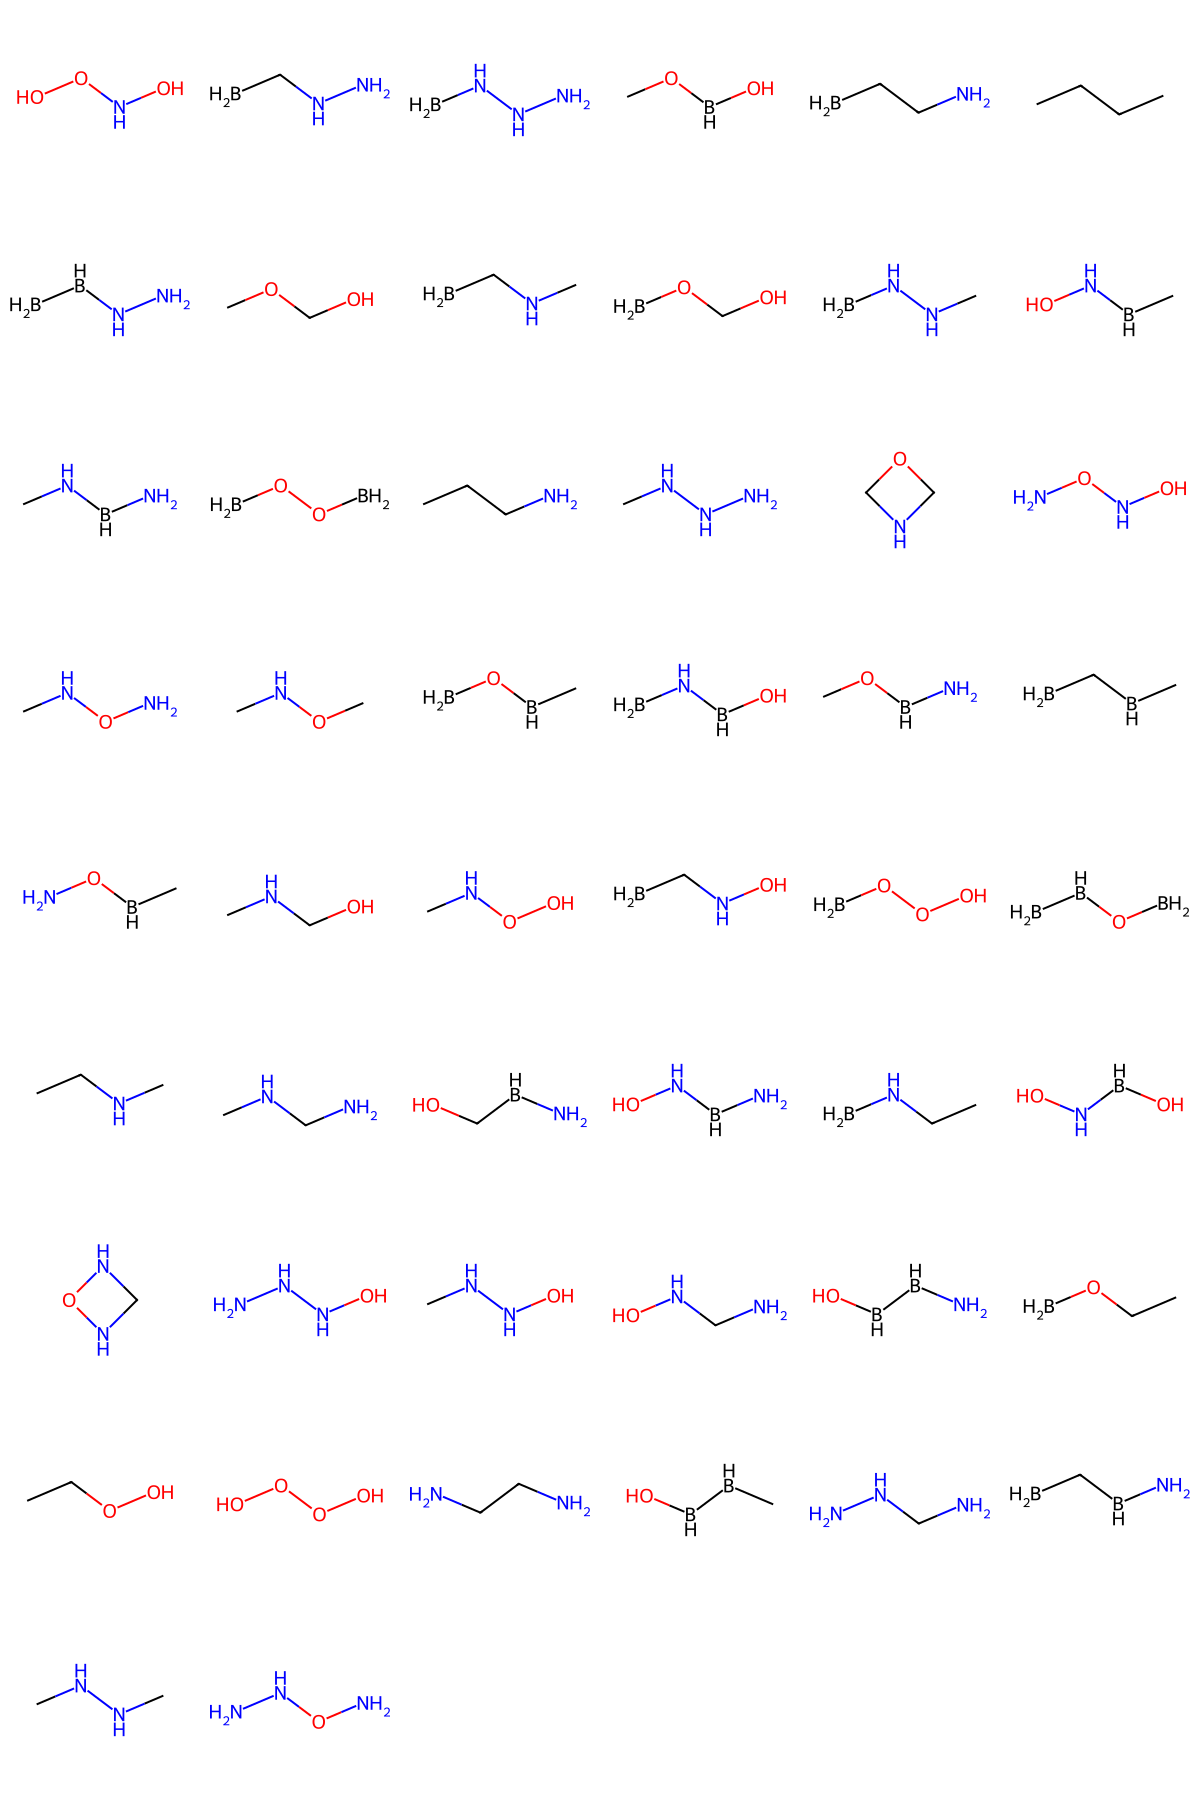

In [81]:
img